In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math

import biojepa_ac_model as model
from bio_dataloader import PretrainLoader, TrainingLoader

## BioJEPA Model load

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
torch.cuda.is_available()

False

In [4]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [5]:
torch.manual_seed(1337)
random.seed(1337)

## Training Configs

In [6]:
data_dir = Path('/Users/djemec/data/jepa/v0_2')
train_dir = data_dir / 'training'
pretrain_dir = data_dir / 'pretraining'
checkpoint_dir = Path('/Users/djemec/data/jepa/v0_3') / 'checkpoints'
pert_dir = data_dir / 'pert_embd'
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'

In [7]:
print('Loading Action Embedding ...')
pert_embd = np.load(pert_embd_path)
print(f'Bank Loaded. Shape: {pert_embd.shape}')

Loading Action Embedding ...
Bank Loaded. Shape: (1087, 320)


In [8]:
batch_size = 32
n_embd = 8
pt_epochs = 10
training_file_chunk = 25000
pretraining_file_chunk = 50000
n_heads = 2
n_layers = 2
n_genes = 5000

In [9]:
torch.set_float32_matmul_precision('high')
config = model.BioJepaConfig(
    num_genes = n_genes,
    n_layer= n_layers,
    heads= n_heads,
    embed_dim = n_embd,
    n_pre_layer= n_layers
)
model = model.BioJepa(config, pert_embd=pert_embd).to(DEVICE)

In [10]:
print(f'Student/Teacher: {sum(p.numel() for p in model.student.parameters() if p.requires_grad)}')
print(f'ACpredictor: {sum(p.numel() for p in model.predictor.parameters() if p.requires_grad)}')

Student/Teacher: 41784
ACpredictor: 45168


### Pre-Training

In [11]:
pt_train_loader = PretrainLoader(batch_size=batch_size, split='train', data_dir=pretrain_dir, device=DEVICE)
pt_val_loader = PretrainLoader(batch_size=batch_size, split='val', data_dir=pretrain_dir, device=DEVICE)

found 3 shards for split train
loading /Users/djemec/data/jepa/v0_2/pretraining/train/pt_shard_k562e_train_0000.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/v0_2/pretraining/val/pt_shard_k562e_val_0000.npz


In [12]:
pt_train_total = 112373
pt_val_total = 11044
steps_per_epoch = pt_train_total // batch_size
pt_max_steps = pt_epochs * steps_per_epoch
steps_per_epoch, pt_max_steps

(3511, 35110)

In [13]:
pt_LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=pt_LR, weight_decay=0.05)

In [14]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=pt_LR, total_steps=pt_max_steps, pct_start=0.05
)

In [15]:
pt_lossi = []
step = 0
total_epoch_loss = 0

In [16]:
model.train()

for step in range(pt_max_steps):
    last_step = (step == pt_max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                x_val, total_val = pt_val_loader.next_batch()

                val_loss = model.forward_pretrain(x_val, total_val)
                val_loss_accum += val_loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')
            
        # with open(log_file, 'a') as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        model.train()


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}.pt')

    # Pre-Training
    x, total = pt_train_loader.next_batch()
    
    optimizer.zero_grad()
    
    loss = model.forward_pretrain(x, total)
    loss.backward()

    # gradient clipping
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    # Update Teacher (V-JEPA Momentum)
    model.update_teacher()
    
    scheduler.step()
    
    pt_lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f'Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}')
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f'=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===')
        total_epoch_loss = 0.0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}_final.pt')



val loss: 70.5124
Step 0 | Loss: 70.51642 | LR: 4.00e-05
Step 25 | Loss: 69.35999 | LR: 4.05e-05
Step 50 | Loss: 68.15260 | LR: 4.20e-05
Step 75 | Loss: 66.90420 | LR: 4.44e-05
val loss: 65.8945
Step 100 | Loss: 65.90283 | LR: 4.78e-05
Step 125 | Loss: 64.98123 | LR: 5.22e-05
Step 150 | Loss: 63.93257 | LR: 5.74e-05
Step 175 | Loss: 63.09954 | LR: 6.36e-05
val loss: 62.4035
Step 200 | Loss: 62.40166 | LR: 7.08e-05
Step 225 | Loss: 61.58796 | LR: 7.88e-05
Step 250 | Loss: 60.71675 | LR: 8.77e-05
Step 275 | Loss: 59.84777 | LR: 9.74e-05
val loss: 58.8063
Step 300 | Loss: 58.80900 | LR: 1.08e-04
Step 325 | Loss: 57.57399 | LR: 1.19e-04
Step 350 | Loss: 56.22563 | LR: 1.32e-04
Step 375 | Loss: 55.74198 | LR: 1.45e-04
val loss: 55.2458
Step 400 | Loss: 55.23922 | LR: 1.59e-04
Step 425 | Loss: 54.80299 | LR: 1.73e-04
Step 450 | Loss: 54.27722 | LR: 1.88e-04
Step 475 | Loss: 53.64861 | LR: 2.04e-04
val loss: 53.0503
Step 500 | Loss: 53.04535 | LR: 2.21e-04
Step 525 | Loss: 52.45620 | LR: 2.38

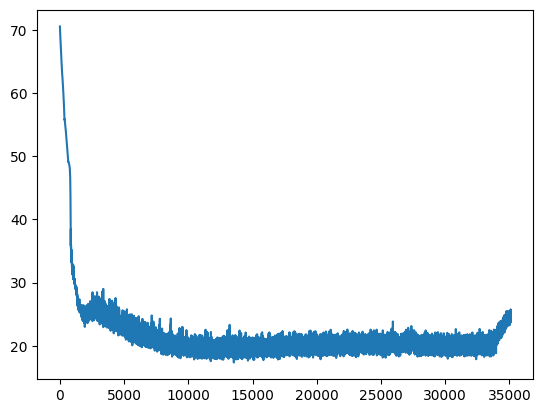

In [27]:
plt.plot(pt_lossi[:])
#plt.yscale('log')

## Training

In [18]:
batch_size = 32
LR = 1e-3
epochs = 10

In [19]:
train_loader = TrainingLoader(batch_size=batch_size, split='train', data_dir=train_dir, device=DEVICE)
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)

found 5 shards for split train
loading /Users/djemec/data/jepa/v0_2/training/train/shard_k562e_train_0000.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/v0_2/training/val/shard_k562e_val_0000.npz


In [20]:
steps_per_epoch = 101682 // batch_size
max_steps = epochs * steps_per_epoch
steps_per_epoch, max_steps

(3177, 31770)

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

In [22]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, total_steps=max_steps, pct_start=0.05
)

In [23]:
lossi = []
step = 0
total_epoch_loss = 0

In [24]:
model.freeze_encoders()
model.train()

for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                xc, xct, xt, xtt, aid = val_loader.next_batch()

                val_loss = model(xc, xct, xt, xtt, aid)
                val_loss_accum += val_loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')

        # with open(log_file, "a") as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        model.train()


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}.pt')


    # Get Batch (xc=Control, xt=Treated/Case)
    xc, xct, xt, xtt, aid = train_loader.next_batch()
    
    optimizer.zero_grad()
    
    loss = model(xc, xct, xt, xtt, aid)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    
    scheduler.step()
    
    lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}_final.pt')



val loss: 64.8146
Step 0 | Loss: 64.87175 | LR: 4.00e-05
Step 25 | Loss: 63.30478 | LR: 4.06e-05
Step 50 | Loss: 61.67375 | LR: 4.24e-05
Step 75 | Loss: 60.21461 | LR: 4.54e-05
val loss: 57.6717
Step 100 | Loss: 57.81680 | LR: 4.96e-05
Step 125 | Loss: 55.10645 | LR: 5.48e-05
Step 150 | Loss: 52.23032 | LR: 6.13e-05
Step 175 | Loss: 50.44062 | LR: 6.88e-05
val loss: 48.8697
Step 200 | Loss: 48.46856 | LR: 7.75e-05
Step 225 | Loss: 46.92067 | LR: 8.72e-05
Step 250 | Loss: 46.51177 | LR: 9.80e-05
Step 275 | Loss: 45.50906 | LR: 1.10e-04
val loss: 44.6137
Step 300 | Loss: 44.25595 | LR: 1.23e-04
Step 325 | Loss: 43.88667 | LR: 1.36e-04
Step 350 | Loss: 43.37792 | LR: 1.51e-04
Step 375 | Loss: 41.55660 | LR: 1.67e-04
val loss: 41.1930
Step 400 | Loss: 41.37983 | LR: 1.83e-04
Step 425 | Loss: 41.68024 | LR: 2.01e-04
Step 450 | Loss: 39.85073 | LR: 2.19e-04
Step 475 | Loss: 38.66870 | LR: 2.38e-04
val loss: 38.1188
Step 500 | Loss: 37.40548 | LR: 2.57e-04
Step 525 | Loss: 35.84142 | LR: 2.77

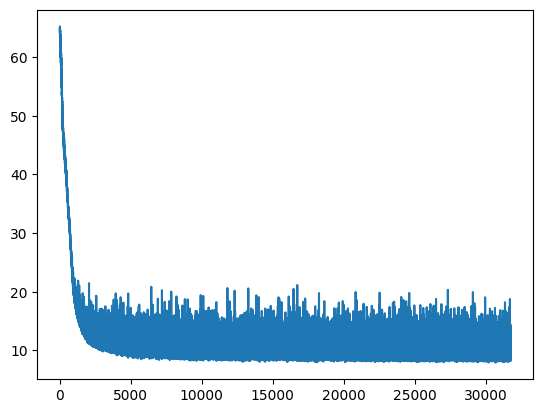

In [26]:
plt.plot(lossi[:])
#plt.yscale('log')